In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# --- Дані ---
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)   # (60000, 28, 28)
print(y_train.shape)   # (60000,)
print(x_test.shape)    # (10000, 28, 28)
print(y_test.shape)    # (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


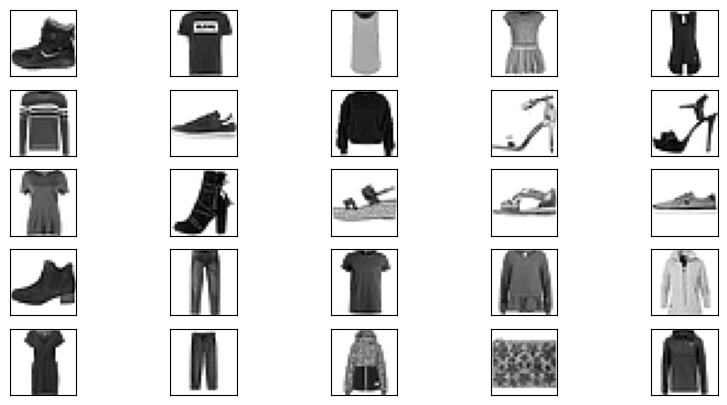

In [5]:
#робимо стандартизацію
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train_cat=keras.utils.to_categorical(y_train,10)
y_test_cat=keras.utils.to_categorical(y_test  ,10)

# Виводимо перші 25 зображень
plt.figure(figsize=(10,5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i],cmap=plt.cm.binary)
plt.show()

In [6]:

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, Nadam

# побудовa моделі
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # кількість шарів
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(Dense(
            units=hp.Int(f"units_{i}", min_value=64, max_value=512, step=64),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=0.3))

    model.add(Dense(10, activation="softmax"))

    # вибір оптимізатора
    optimizer_choice = hp.Choice("optimizer", ["adam", "nadam"])
    if optimizer_choice == "adam":
        optimizer = Adam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        )
    else:
        optimizer = Nadam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory=r"D:\PYTHON_LEARNING\HW_12_ML\dir_tuner",
    project_name="mnist_tuning"
)



Reloading Tuner from D:\PYTHON_LEARNING\HW_12_ML\dir_tuner\mnist_tuning\tuner0.json


In [7]:
tuner.search(x_train, y_train_cat, epochs=20, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model.summary())

C:\Users\Sveta\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Sveta\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 19 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 448)                 │         351,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 384)                 │         172,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 574,666 (2.19 MB)

 Trainable params: 574,666 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
#за допомогою тюнеру отримала НМ з наступними шарами : вх 784 нейр-448 нейронів-384 нейрони-128 нейрони-вих 10 класів 
# поступово зменьшувала кількість епох
history = best_model.fit(
    x_train, y_train_cat,
    batch_size=16,#32, 16
    epochs=5,  # 60, 30, 20, 10, 5 епох
    validation_split=0.1 #0,2 0,1
)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.9651 - loss: 0.1025 - val_accuracy: 0.8830 - val_loss: 1.0209
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.9638 - loss: 0.1080 - val_accuracy: 0.8807 - val_loss: 1.0043
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9634 - loss: 0.1105 - val_accuracy: 0.8915 - val_loss: 0.9844
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9639 - loss: 0.1082 - val_accuracy: 0.8955 - val_loss: 0.8908
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9662 - loss: 0.0991 - val_accuracy: 0.8918 - val_loss: 0.8478


In [33]:
best_model.evaluate(x_test,y_test_cat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8937 - loss: 0.8533


[0.8533493280410767, 0.8937000036239624]

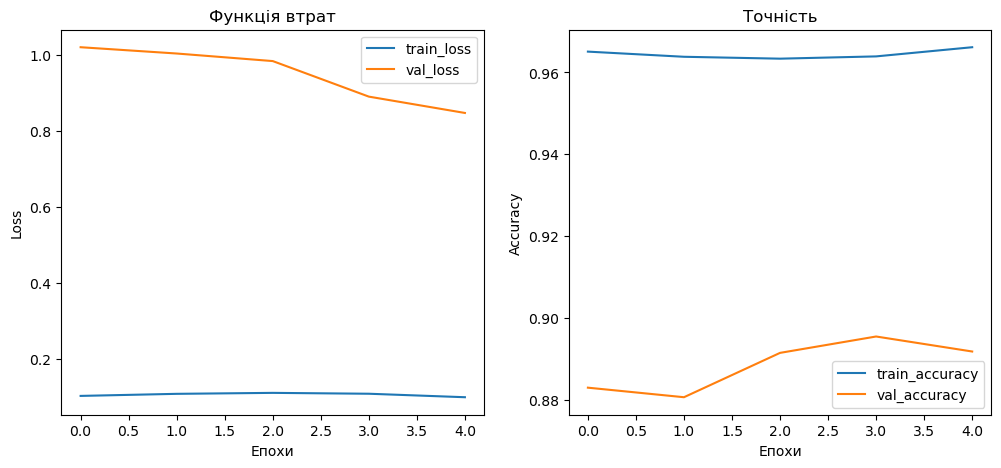

In [34]:
# графіки залежності зміни точності і втрат від кроку

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Функція втрат")
plt.xlabel("Епохи")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Точність")
plt.xlabel("Епохи")
plt.ylabel("Accuracy")
plt.legend()

plt.show()



Точність на тестових даних: 0.8937
Модель помиляється у 10.63% випадків


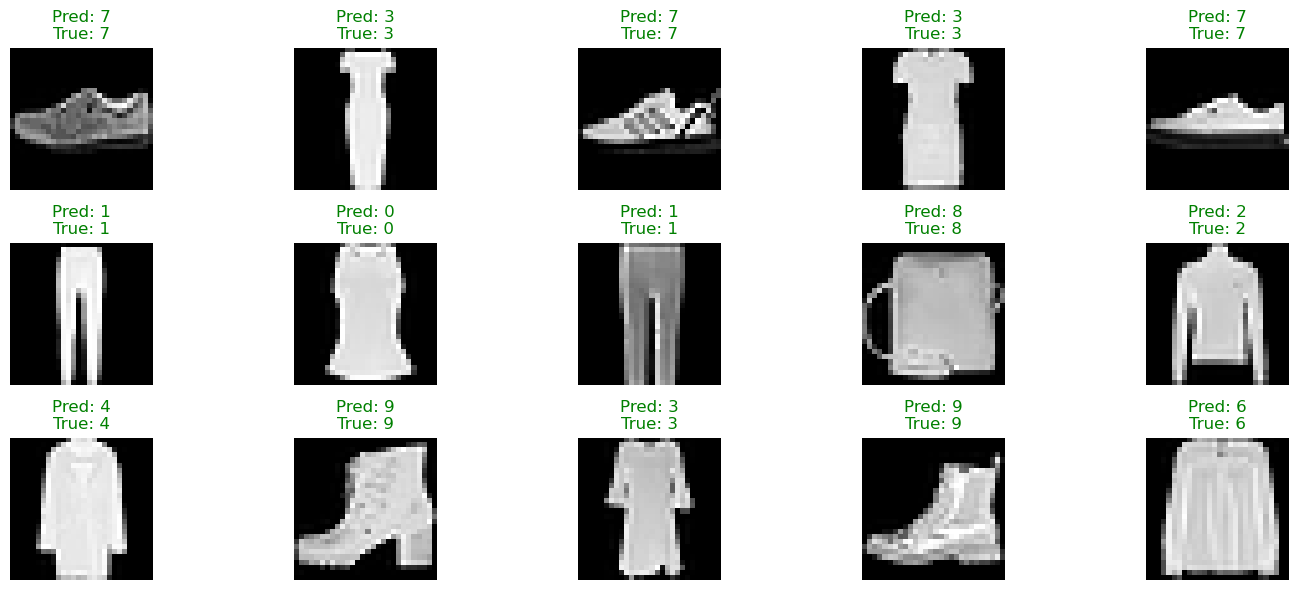

In [35]:
# вивод 15 випадкових передбачених зображень
import random
import matplotlib.pyplot as plt
import numpy as np

# робимо передбачення для всіх тестових
pred_all = best_model.predict(x_test, verbose=0)
pred_classes = np.argmax(pred_all, axis=1)

# рахуємо точність
accuracy = np.mean(pred_classes == y_test)
print(f"Точність на тестових даних: {accuracy:.4f}")
print(f"Модель помиляється у {100*(1-accuracy):.2f}% випадків")

# показуємо 15 випадкових зображень
plt.figure(figsize=(15, 6))
for i in range(15):
    idx = random.randint(0, x_test.shape[0] - 1)
    img = x_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    pred_label = pred_classes[idx]

    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap="gray")
    # колір підпису: зелений = правильно, червоний = помилка
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()